It's a summary after the long fine-tuning results in build_models_08.ipynb.

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('ggplot')
plt.style.use('dark_background')
#plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True

from nwp_cali import PrepareData
from joblib import load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Final grid search results

In [2]:
def plot_score_time(df):
    plt.figure()
    # plot the positive scores
    sns.scatterplot(data=df[df.mean_test_score > 0], x='param_svr__C', y='param_svr__gamma', 
                    size='mean_fit_time', hue='mean_test_score', palette='Blues_r')
    # plot the negative scores
    plt.scatter(x=df.loc[df.mean_test_score < 0, 'param_svr__C'], 
                y=df.loc[df.mean_test_score < 0, 'param_svr__gamma'],
                marker='X')
    # mark the best score
    test_max = np.argmax(df.mean_test_score)
    plt.scatter(df.param_svr__C[test_max], df.param_svr__gamma[test_max], 
                edgecolors='orange', facecolors='none', linewidths=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1))

In [2]:
def n_scores(df):
    scores = []
    for n in np.unique(df.param_nmf__n_components):
        data = df[df.param_nmf__n_components == n]
        max_score = data.mean_test_score.max()
        scores = np.hstack((scores, 
                            data.loc[data.mean_test_score == max_score, 'mean_test_score'].values))
    return scores

### CaCO3

In [3]:
caco3_df = pd.concat([pd.read_csv('results/caco3_grid_nmf+svr_20210820.csv', index_col=0),
                      pd.read_csv('results/caco3_grid_nmf+svr_20210823.csv', index_col=0),
                      pd.read_csv('results/caco3_grid_nmf+svr_1_20210823.csv', index_col=0),
                      pd.read_csv('results/caco3_grid_nmf+svr_2-1_20210823.csv', index_col=0),
                      pd.read_csv('results/caco3_grid_nmf+svr_2-2_20210823.csv', index_col=0)],
                     axis=0, join='inner').reset_index(drop=True)
caco3_df.shape

(349, 21)

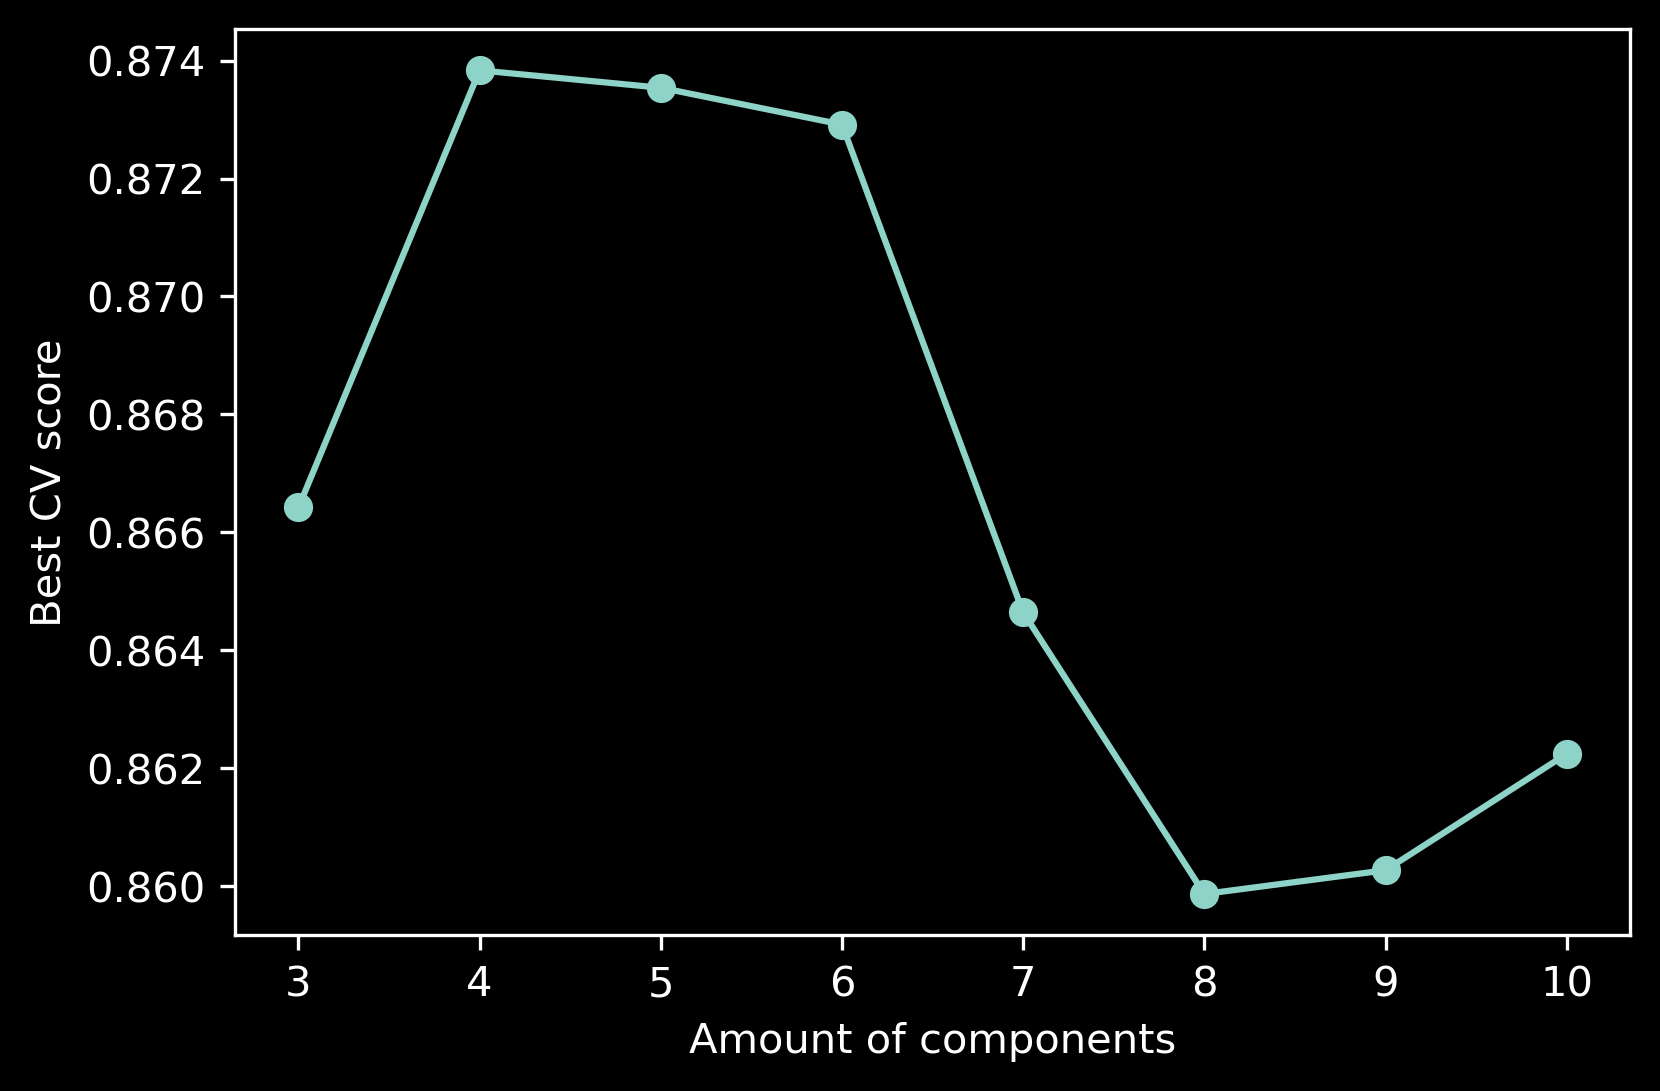

In [4]:
plt.plot(np.unique(caco3_df.param_nmf__n_components), n_scores(caco3_df), marker='o')
plt.xlabel('Amount of components')
plt.ylabel('Best CV score')
plt.savefig('results/caco3_scores_components_{}.png'.format(date))

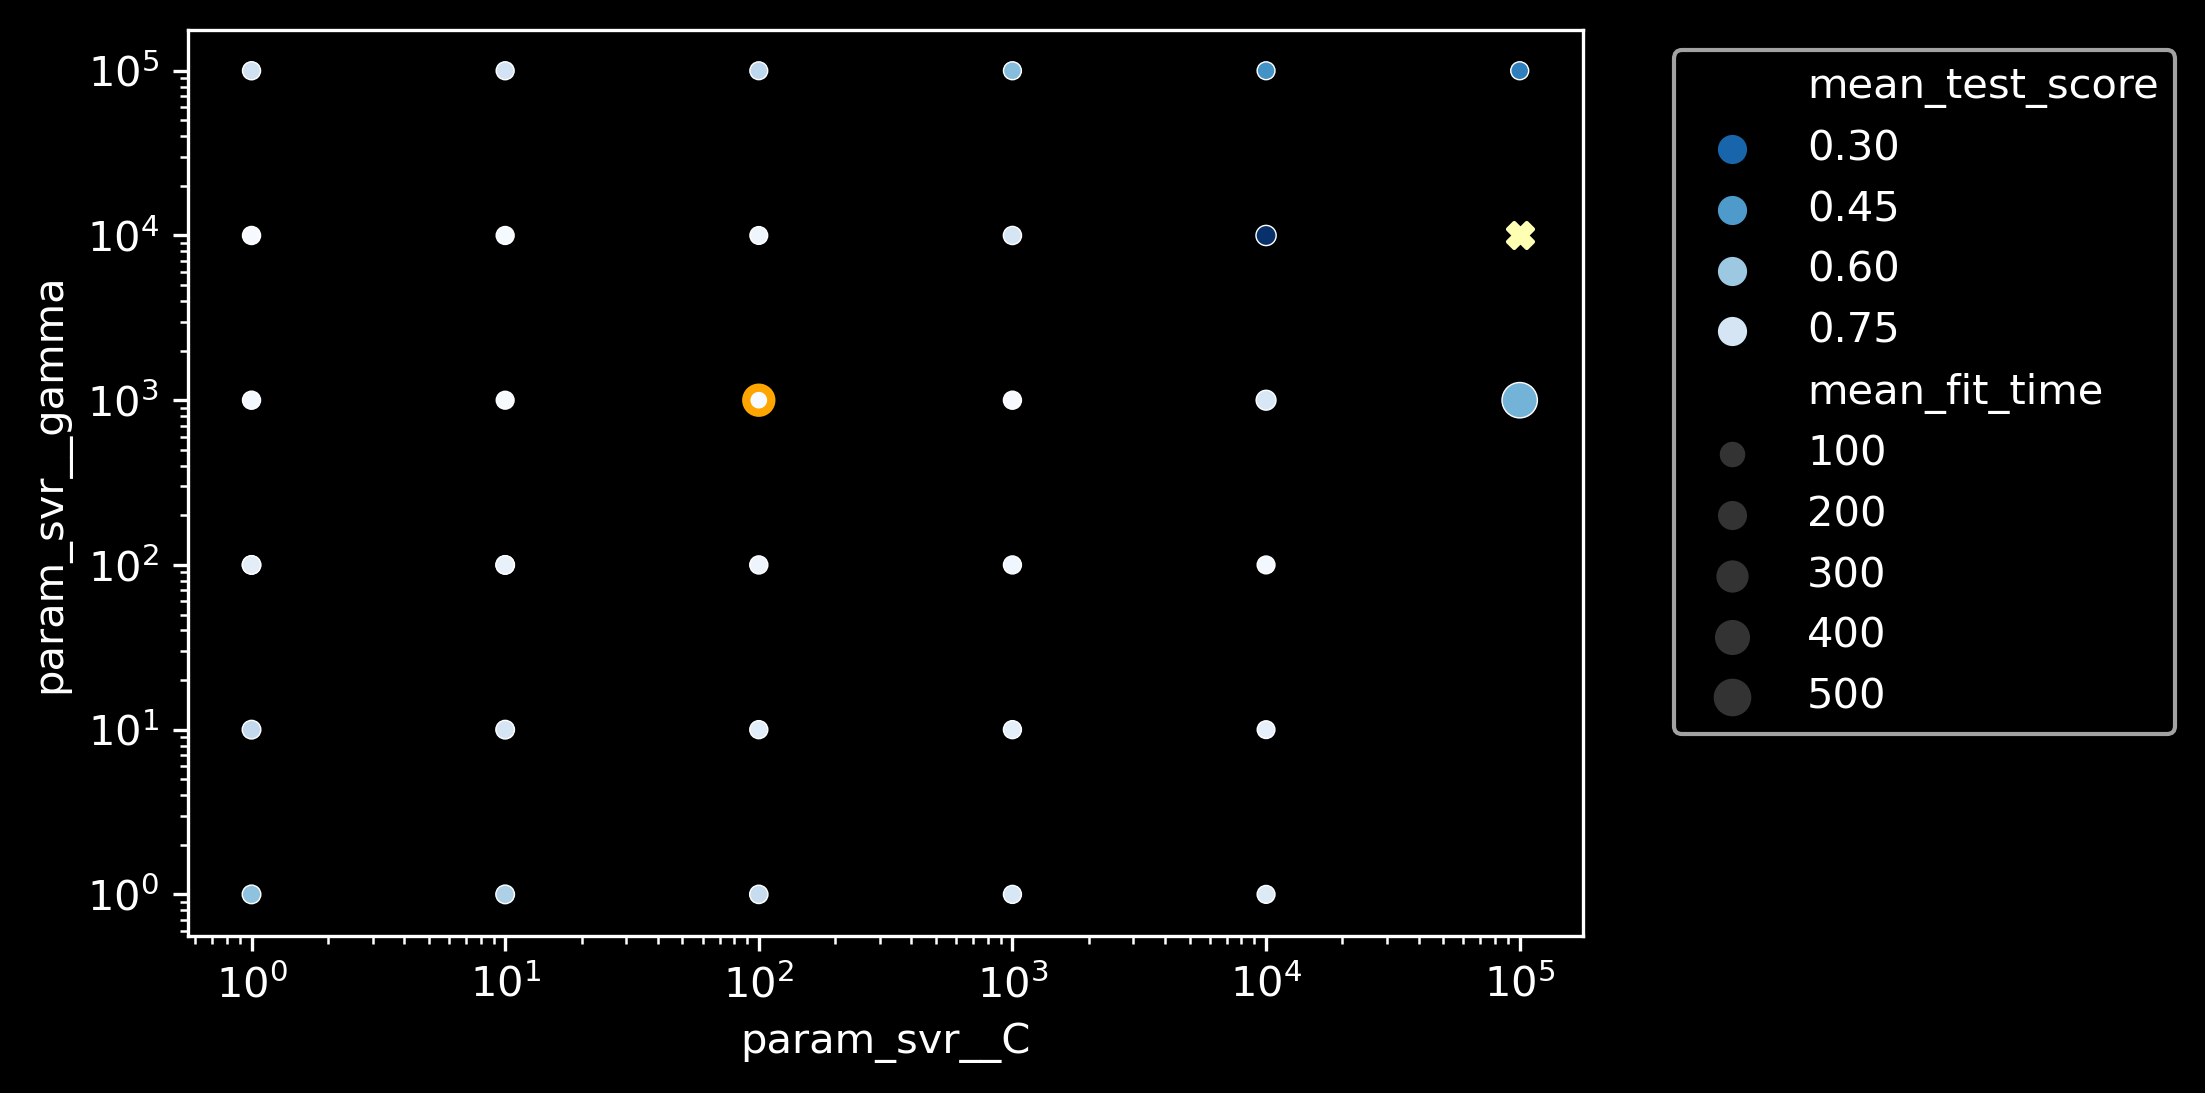

In [11]:
df = caco3_df[caco3_df.param_nmf__n_components == 4].reset_index(drop=True)
plot_score_time(df)
plt.savefig('results/caco3_grid_4nmf+svr_{}.png'.format(date))

### TOC

In [5]:
toc_df = pd.concat([pd.read_csv('results/toc_grid_nmf+svr_20210821.csv', index_col=0),
                    pd.read_csv('results/toc_grid_nmf+svr_20210822.csv', index_col=0),
                    pd.read_csv('results/toc_grid_nmf+svr_20210823.csv', index_col=0),
                    pd.read_csv('results/toc_grid_nmf+svr_2_20210823.csv', index_col=0)],
                   axis=0, join='inner').reset_index(drop=True)
toc_df.shape

(408, 21)

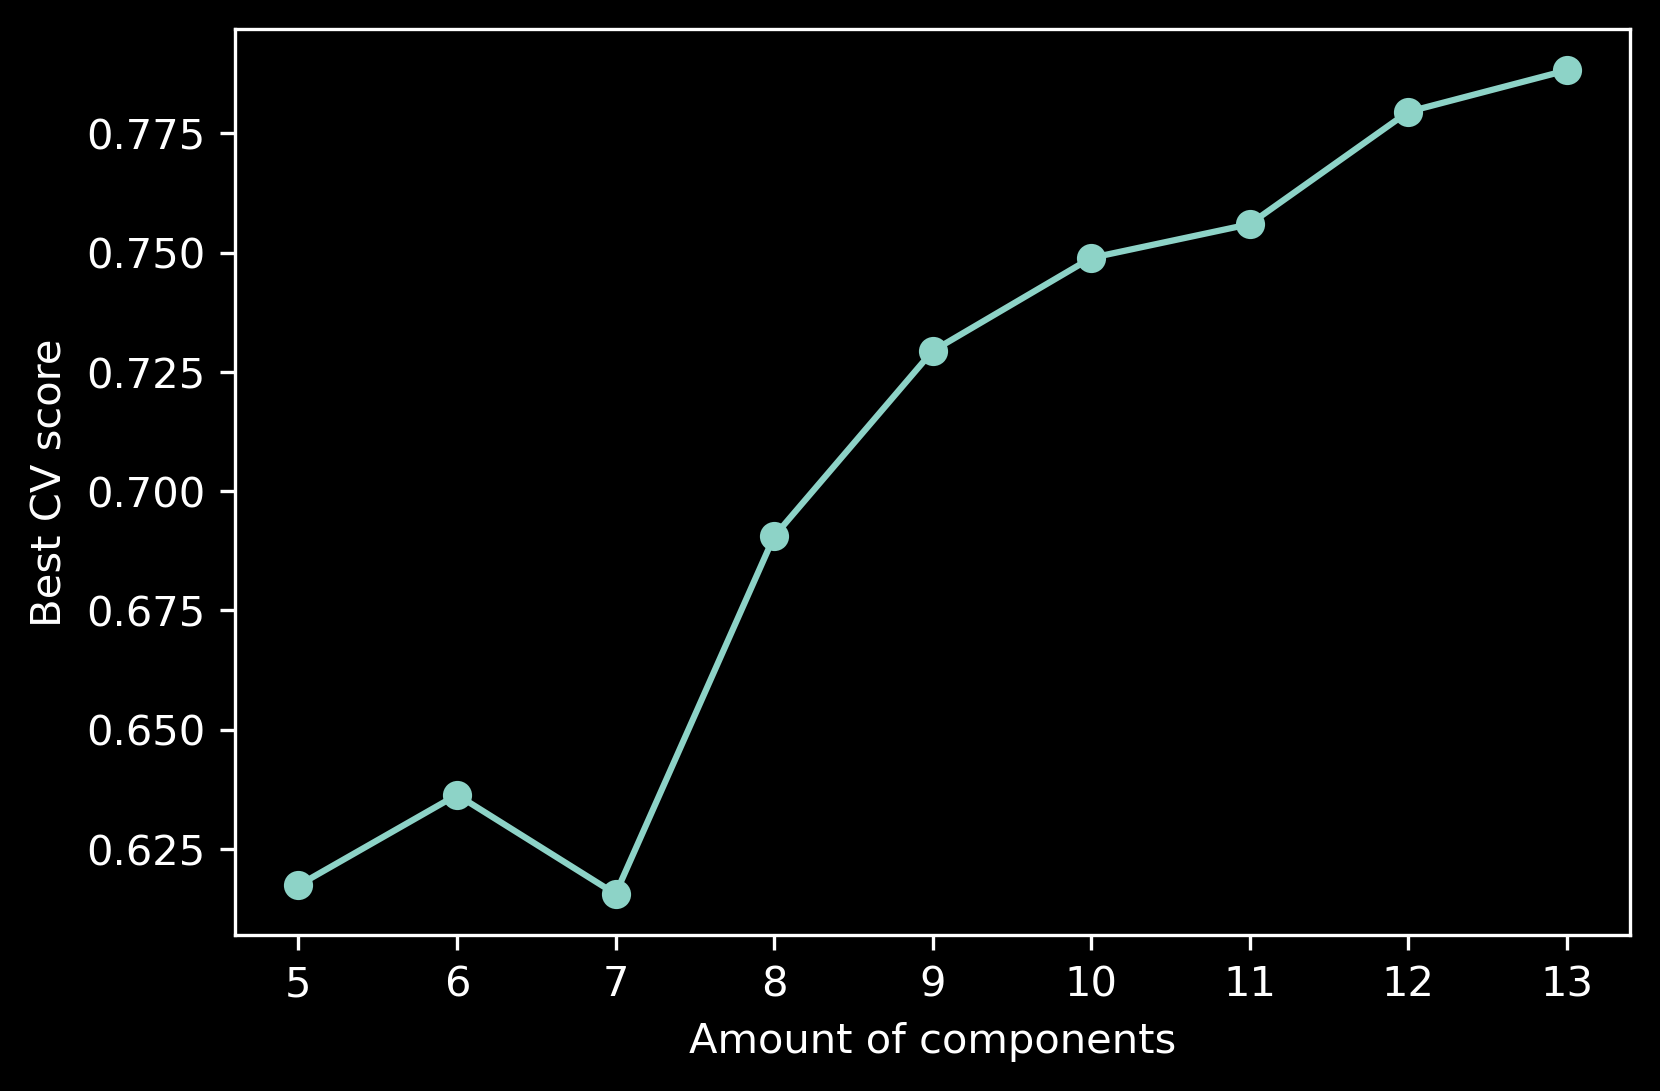

In [6]:
plt.plot(np.unique(toc_df.param_nmf__n_components), n_scores(toc_df), marker='o')
plt.xlabel('Amount of components')
plt.ylabel('Best CV score')
plt.savefig('results/toc_scores_components_{}.png'.format(date))

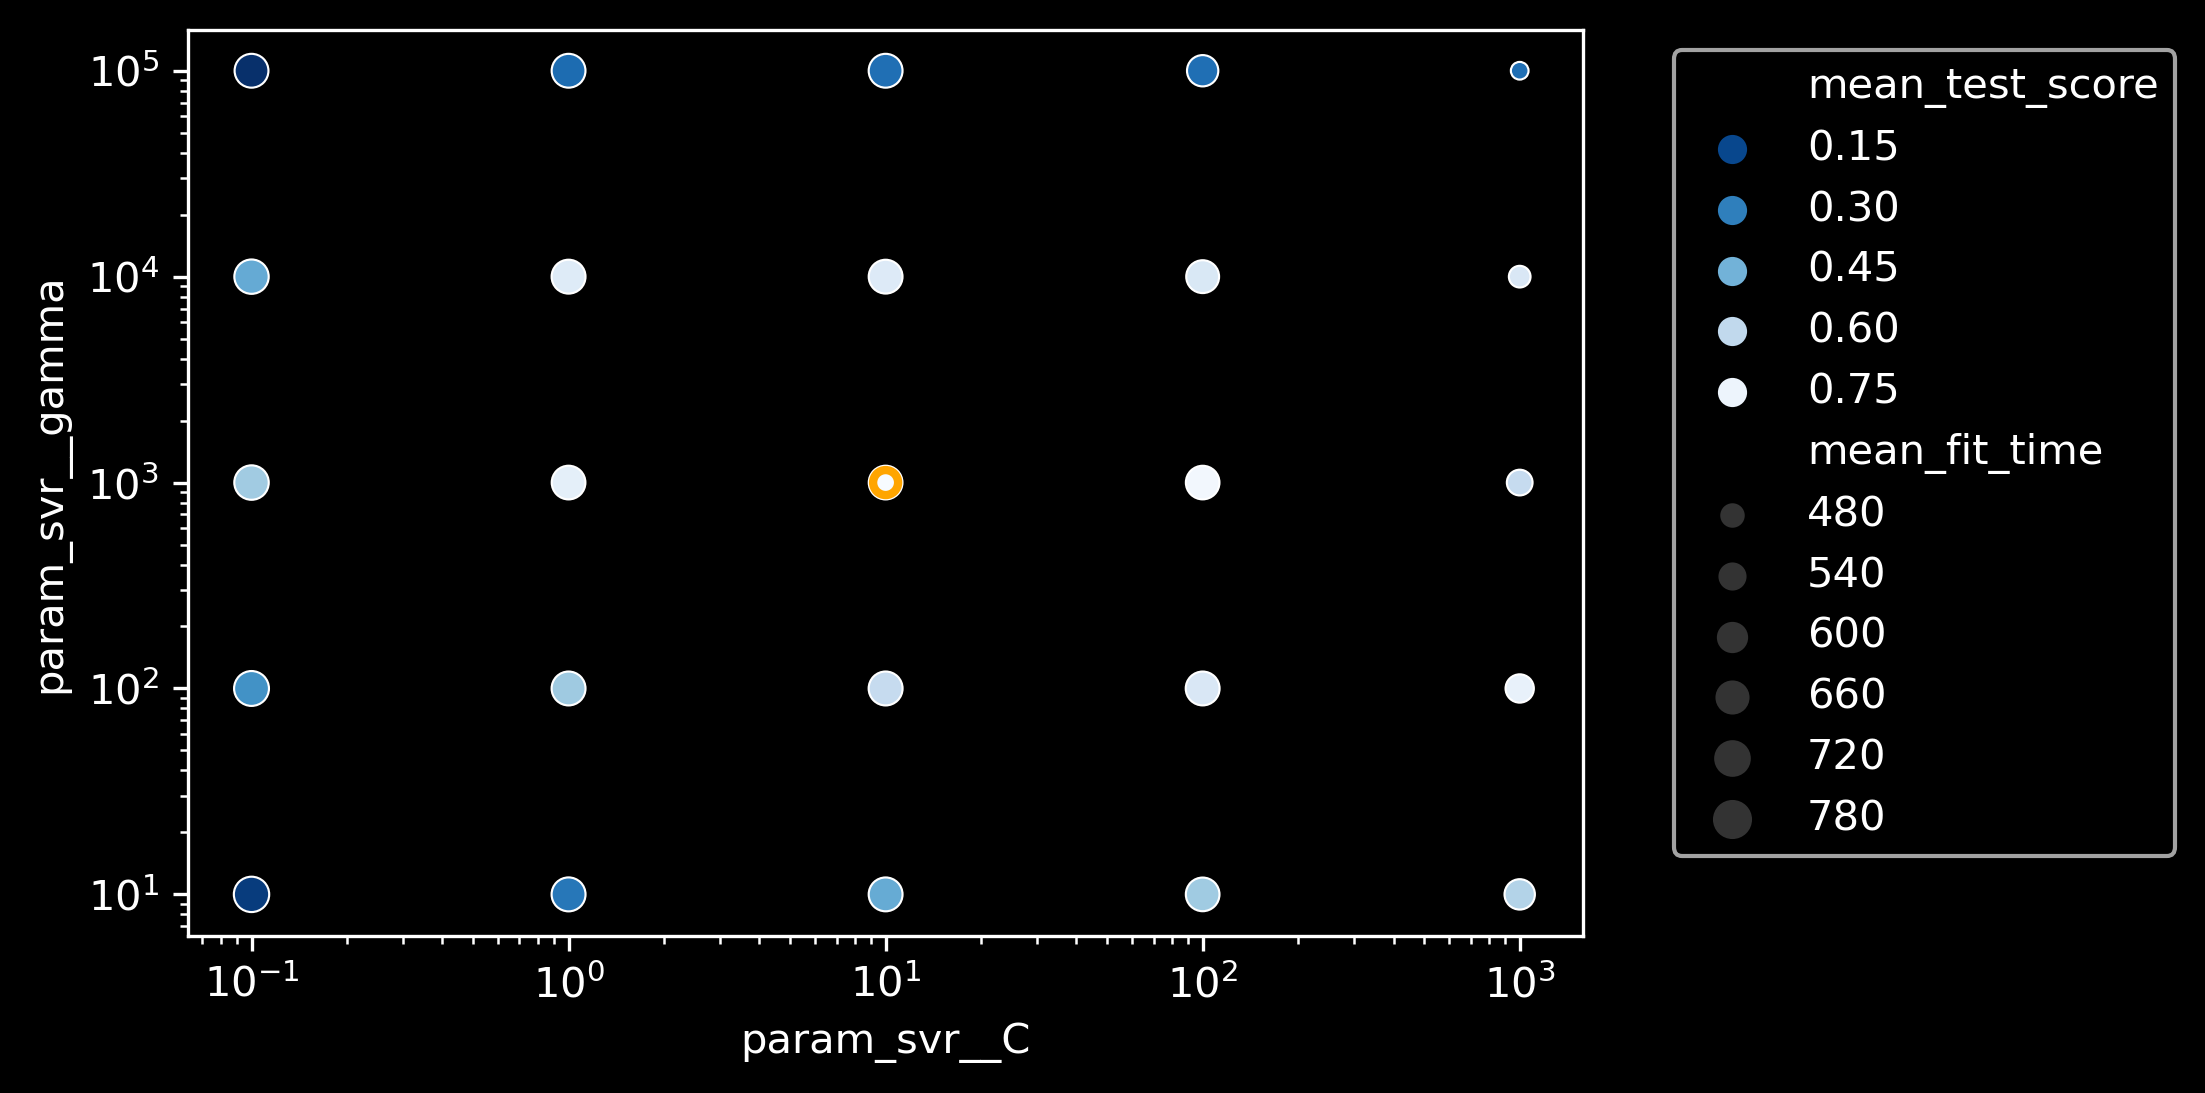

In [19]:
df = toc_df[toc_df.param_nmf__n_components == 13].reset_index(drop=True)
plot_score_time(df)
plt.savefig('results/toc_grid_13nmf+svr_{}.png'.format(date))

In [ ]:
grids_df = pd.concat([caco3_df, toc_df], axis=0, join='outer')
grids_df['measurement'] = np.hstack((['CaCO3' for _ in range(len(caco3_df))], 
                           ['TOC' for _ in range(len(toc_df))]))
grids_df.to_csv('results/grid_caco3+toc_compile_{}.csv'.format(date))

## Summary
There are 349 and 408 parameter sets tried to find the optimal set. The parameters are initialized based on the result of the pilottest. In general, the optimal parameters are found at the middle of the CV score platue. Only several exceptions caused by technical issue are there.

# Check performance on the dev set
The info of the data subsets is illustrated in build_model_08.ipynb.

In [9]:
y_df = pd.read_csv('results/y_dev_preds_20210823.csv', index_col=0)
y_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 393
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CaCO3%       372 non-null    float64
 1   CaCO3%_pred  372 non-null    float64
 2   TOC%         394 non-null    float64
 3   TOC%_pred    394 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


In [6]:
print(len(y_df['CaCO3%']))
print(len(y_df['CaCO3%'].values))
print(len(y_df['CaCO3%'].dropna()))

394
394
372


Okay, the NAs are still counted in either the Series of np.ndarray, so I'll need filter tem out later.

In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

for measurement in ['CaCO3%', 'TOC%']:
    y = y_df[measurement].dropna()
    y_pred = y_df['{}_pred'.format(measurement)].dropna()

    print('Scores in the dev set ({}):'.format(measurement))
    print('R2 = {:.3f} .'.format(r2_score(y, y_pred)))
    print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y, y_pred)))
    print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y, y_pred)))

Scores in the dev set (CaCO3%):
R2 = 0.964 .
The mean absolute error is 1.880 (%, concetration).
The max. residual error is 31.789 (%, concetration).
Scores in the dev set (TOC%):
R2 = 0.778 .
The mean absolute error is 0.036 (%, concetration).
The max. residual error is 0.447 (%, concetration).


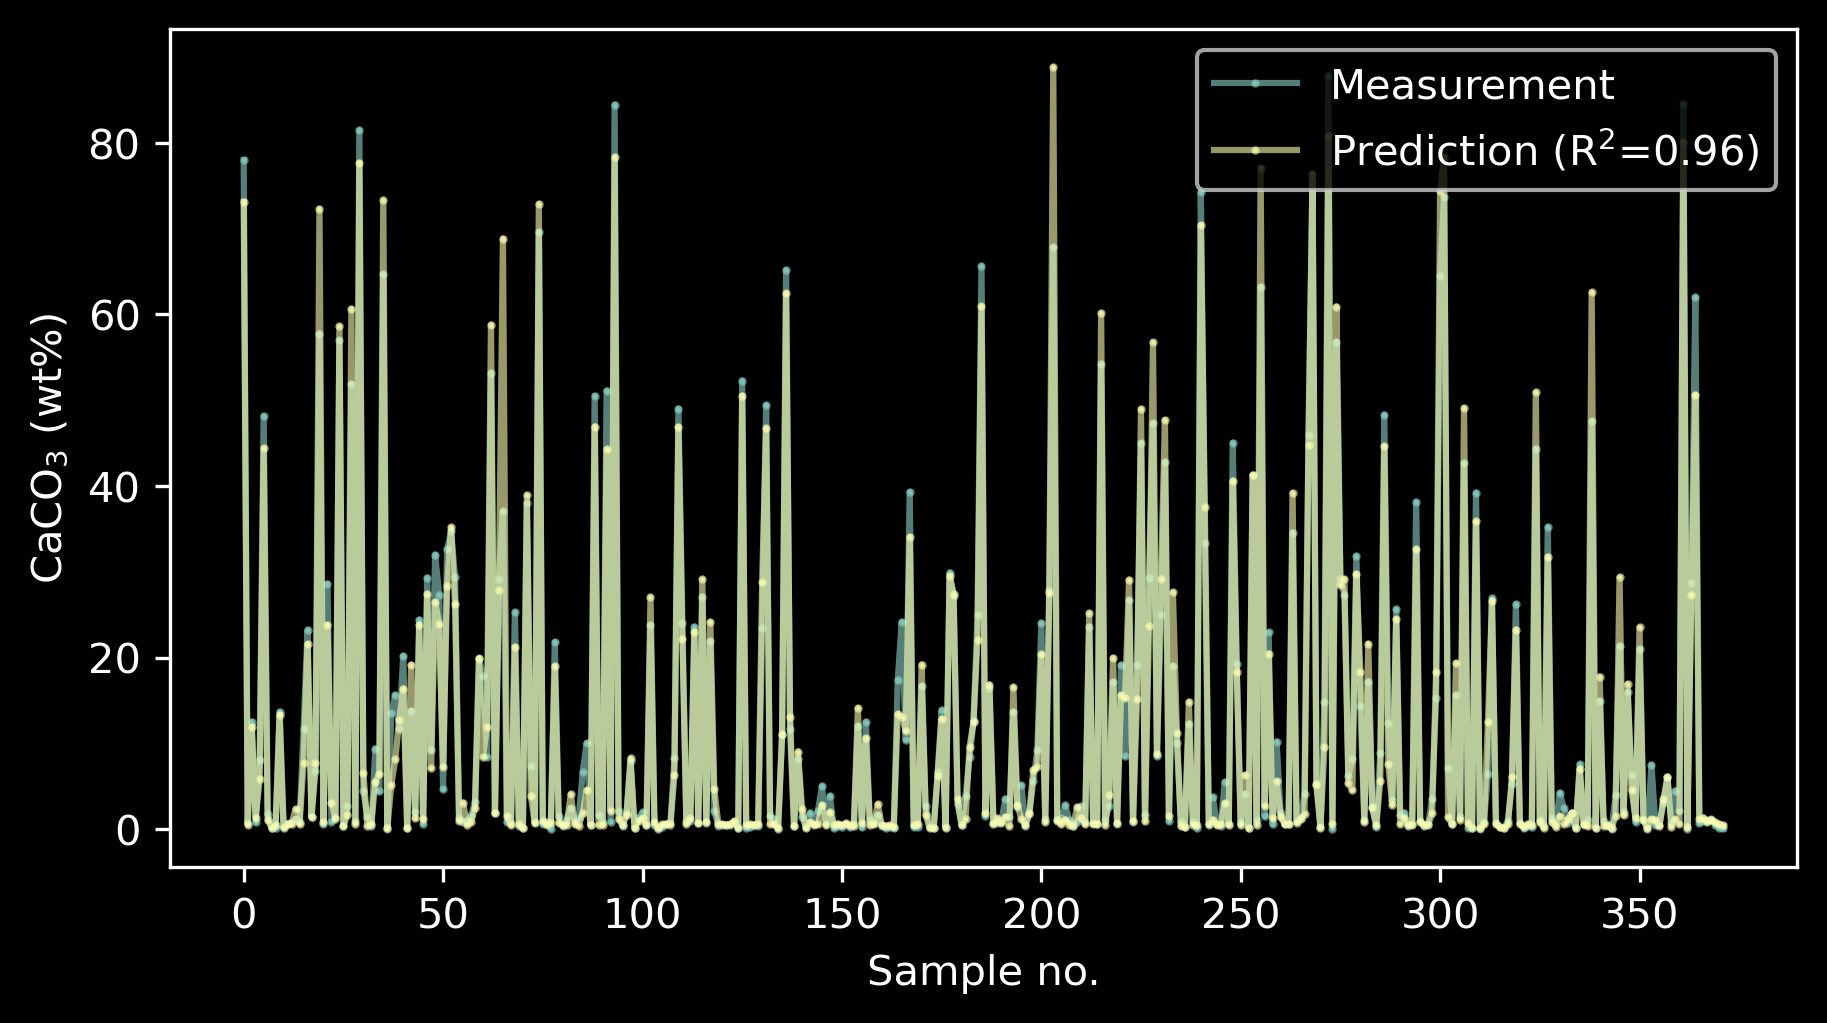

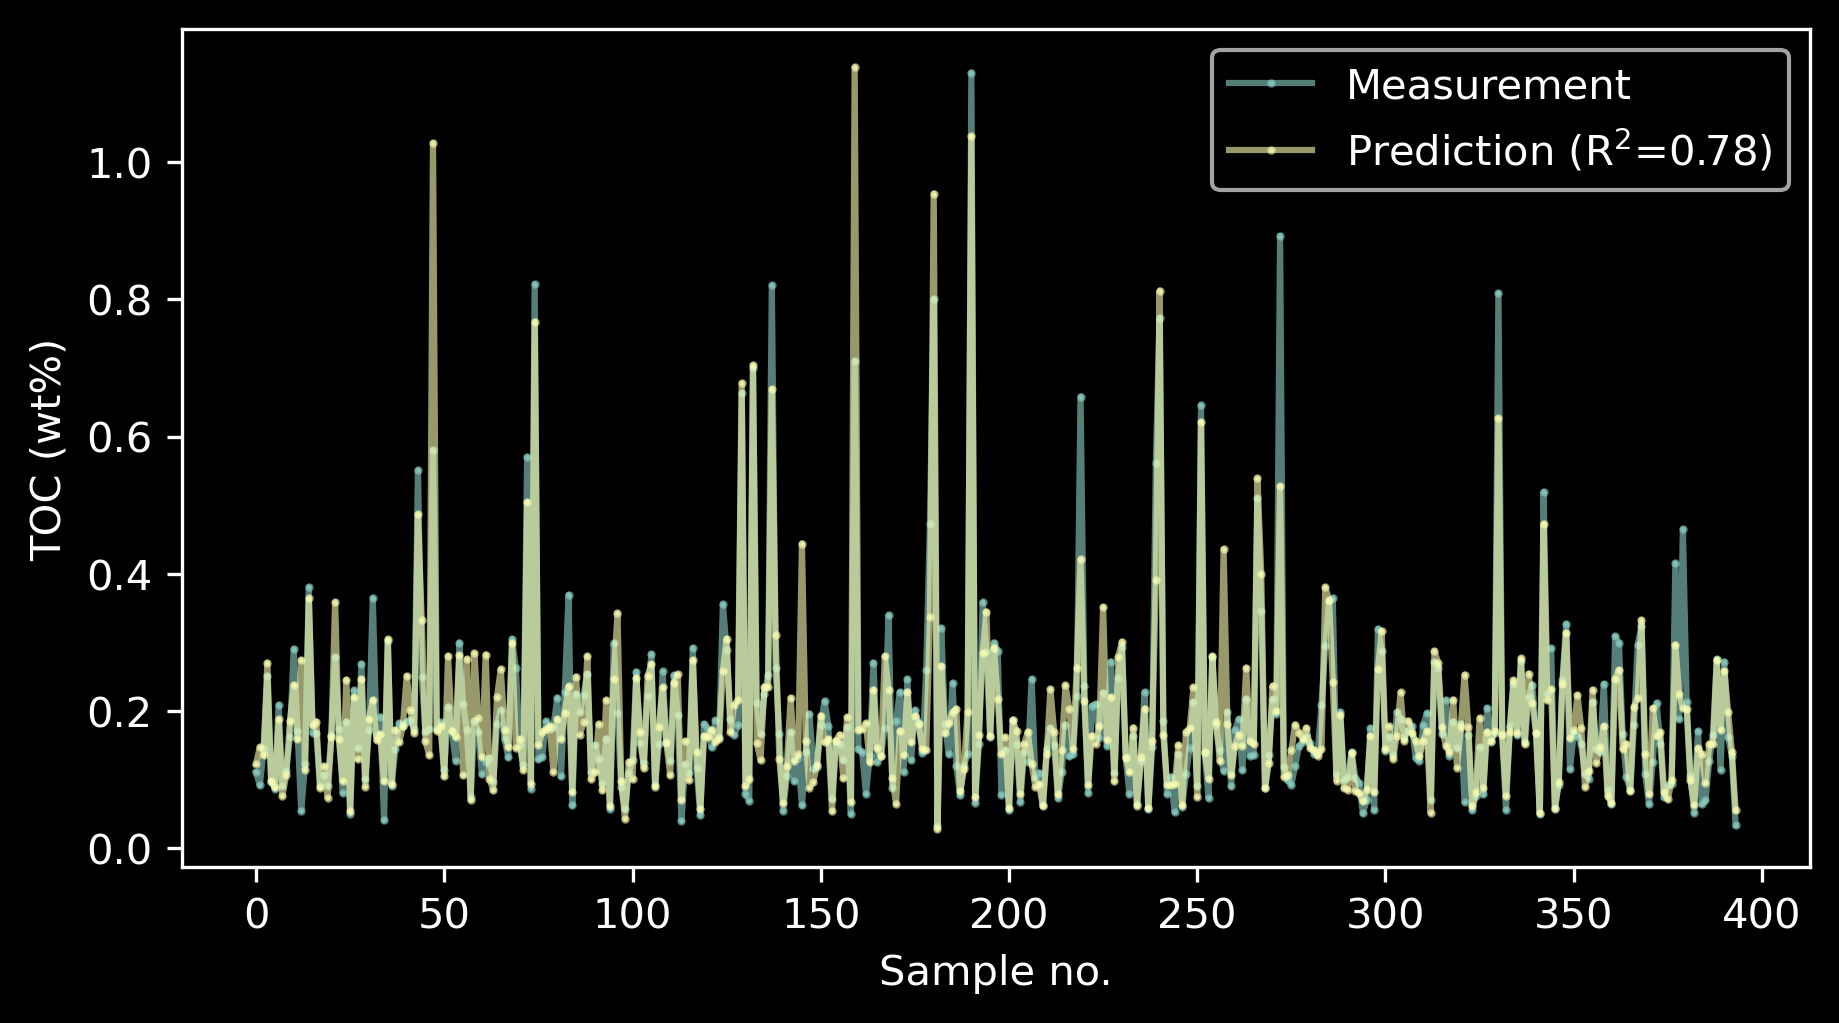

In [26]:
for measurement in ['CaCO3%', 'TOC%']:
    y = y_df[measurement].dropna()
    y_pred = y_df['{}_pred'.format(measurement)].dropna()
    plt.figure(figsize=(7, 3.7))
    plt.plot(range(len(y)), y, marker='o', ms=1, alpha=0.6, label='Measurement')
    plt.plot(range(len(y)), y_pred, marker='o', ms=1, alpha=0.6, label='Prediction (R$^2$={:.2f})'.format(r2_score(y, y_pred)))
    if measurement == 'CaCO3%':
        plt.ylabel('CaCO$_3$ (wt%)')
    else:
        plt.ylabel('TOC (wt%)')
    plt.xlabel('Sample no.')
    plt.legend(loc = 'upper right')
    plt.savefig('results/{}_dev_performance_{}.png'.format(measurement[:-1].lower(), date))

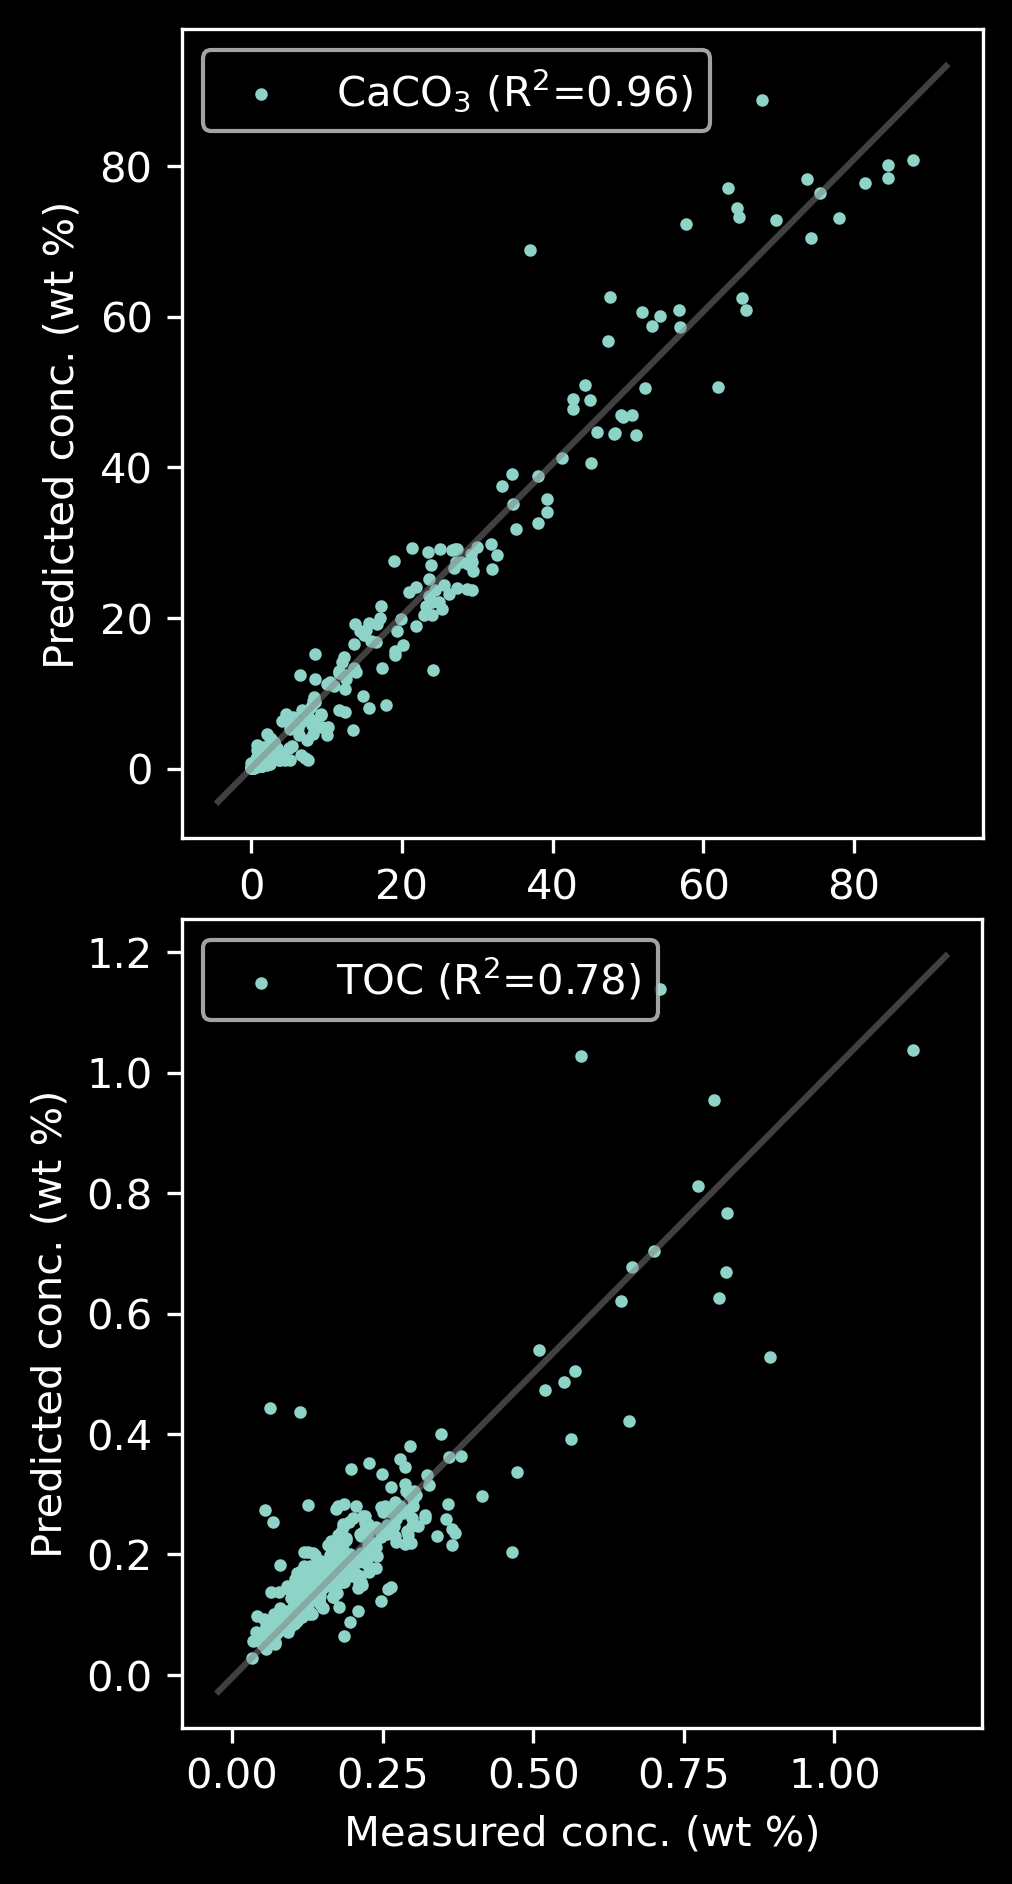

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7.5))

y = y_df['CaCO3%'].dropna()
y_pred = y_df['CaCO3%_pred'].dropna()

ind = np.argsort(y)
axes[0].scatter(y[ind], y_pred[ind], s=4, label='CaCO$_3$ (R$^2$={:.2f})'.format(r2_score(y, y_pred)))
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), alpha=.5, c='gray')
axes[0].set_ylabel('Predicted conc. (wt %)')
axes[0].legend(loc = 'upper left')
axes[0].set_aspect('equal')

y = y_df['TOC%'].dropna()
y_pred = y_df['TOC%_pred'].dropna()

ind = np.argsort(y)
axes[1].scatter(y[ind], y_pred[ind], s=4, label='TOC (R$^2$={:.2f})'.format(r2_score(y, y_pred)))
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), alpha=.5, c='gray')
axes[1].set_ylabel('Predicted conc. (wt %)')
axes[1].set_xlabel('Measured conc. (wt %)')
axes[1].legend(loc = 'upper left')
axes[1].set_aspect('equal')
#axes[1].set_yticks(np.linspace(0, 1.0, 6))

fig.subplots_adjust(hspace=.1)
fig.savefig('results/performance_dev_{}.png'.format(date))

# Check performance on the case study cores

In [2]:
y_df = pd.DataFrame()
for measurement in ['CaCO3%', 'TOC%']:
    model = load('models/{}_nmf+svr_model_20210823.joblib'.format(measurement[:-1].lower()))
    prepare = PrepareData(measurement=measurement)
    data_df = prepare.select_casestudy()
    X, y = prepare.produce_Xy(data_df)

    df = pd.DataFrame()
    df[measurement] = y
    df['{}_core'.format(measurement)] = data_df.core.values
    df['{}_pred'.format(measurement)] = np.exp(model.predict(X))

    y_df = pd.concat([y_df, df], axis=1, join='outer')

In [3]:
y_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CaCO3%       123 non-null    float64
 1   CaCO3%_core  123 non-null    object 
 2   CaCO3%_pred  123 non-null    float64
 3   TOC%         123 non-null    float64
 4   TOC%_core    123 non-null    object 
 5   TOC%_pred    123 non-null    float64
dtypes: float64(4), object(2)
memory usage: 5.9+ KB


Okay, since there is no NA in y_df, which means two cores all have both CaCO3 and TOC measurements. I'm going to produce the y_df in a more tidy way.

In [3]:
measurement = 'CaCO3%'
model = load('models/{}_nmf+svr_model_20210823.joblib'.format(measurement[:-1].lower()))
prepare = PrepareData(measurement=measurement)
data_df = prepare.select_casestudy()
X, y = prepare.produce_Xy(data_df)

y_df = data_df[['core', 'mid_depth_mm']].copy()
y_df[measurement] = y
y_df['{}_pred'.format(measurement)] = np.exp(model.predict(X))

measurement = 'TOC%'
model = load('models/{}_nmf+svr_model_20210823.joblib'.format(measurement[:-1].lower()))
prepare = PrepareData(measurement=measurement)
data_df = prepare.select_casestudy()
X, y = prepare.produce_Xy(data_df)

y_df[measurement] = y
y_df['{}_pred'.format(measurement)] = np.exp(model.predict(X))

y_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 102
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   core          123 non-null    object 
 1   mid_depth_mm  123 non-null    float64
 2   CaCO3%        123 non-null    float64
 3   CaCO3%_pred   123 non-null    float64
 4   TOC%          123 non-null    float64
 5   TOC%_pred     123 non-null    float64
dtypes: float64(5), object(1)
memory usage: 6.7+ KB


In [8]:
for measurement in ['CaCO3%', 'TOC%']:
    for core in ['SO202-37-2_re', 'PS75-056-1']:
        y = y_df.loc[y_df.core == core, measurement].dropna()
        y_pred = y_df.loc[y_df.core == core,'{}_pred'.format(measurement)].dropna()

        print('Scores in the dev set of {} ({}):'.format(core, measurement))
        print('Data amount: {}'.format(len(y)))
        print('R2 = {:.3f} .'.format(r2_score(y, y_pred)))
        print('The mean absolute error is {:.3f} (wt%).'.format(mean_absolute_error(y, y_pred)))
        print('The max. residual error is {:.3f} (wt%).'.format(max_error(y, y_pred)))
        print(' ')

Scores in the dev set of SO202-37-2_re (CaCO3%):
Data amount: 20
R2 = -27.918 .
The mean absolute error is 57.730 (wt%).
The max. residual error is 74.582 (wt%).
 
Scores in the dev set of PS75-056-1 (CaCO3%):
Data amount: 103
R2 = 0.822 .
The mean absolute error is 4.510 (wt%).
The max. residual error is 23.467 (wt%).
 
Scores in the dev set of SO202-37-2_re (TOC%):
Data amount: 20
R2 = 0.028 .
The mean absolute error is 0.053 (wt%).
The max. residual error is 0.149 (wt%).
 
Scores in the dev set of PS75-056-1 (TOC%):
Data amount: 103
R2 = -0.302 .
The mean absolute error is 0.043 (wt%).
The max. residual error is 0.198 (wt%).
 


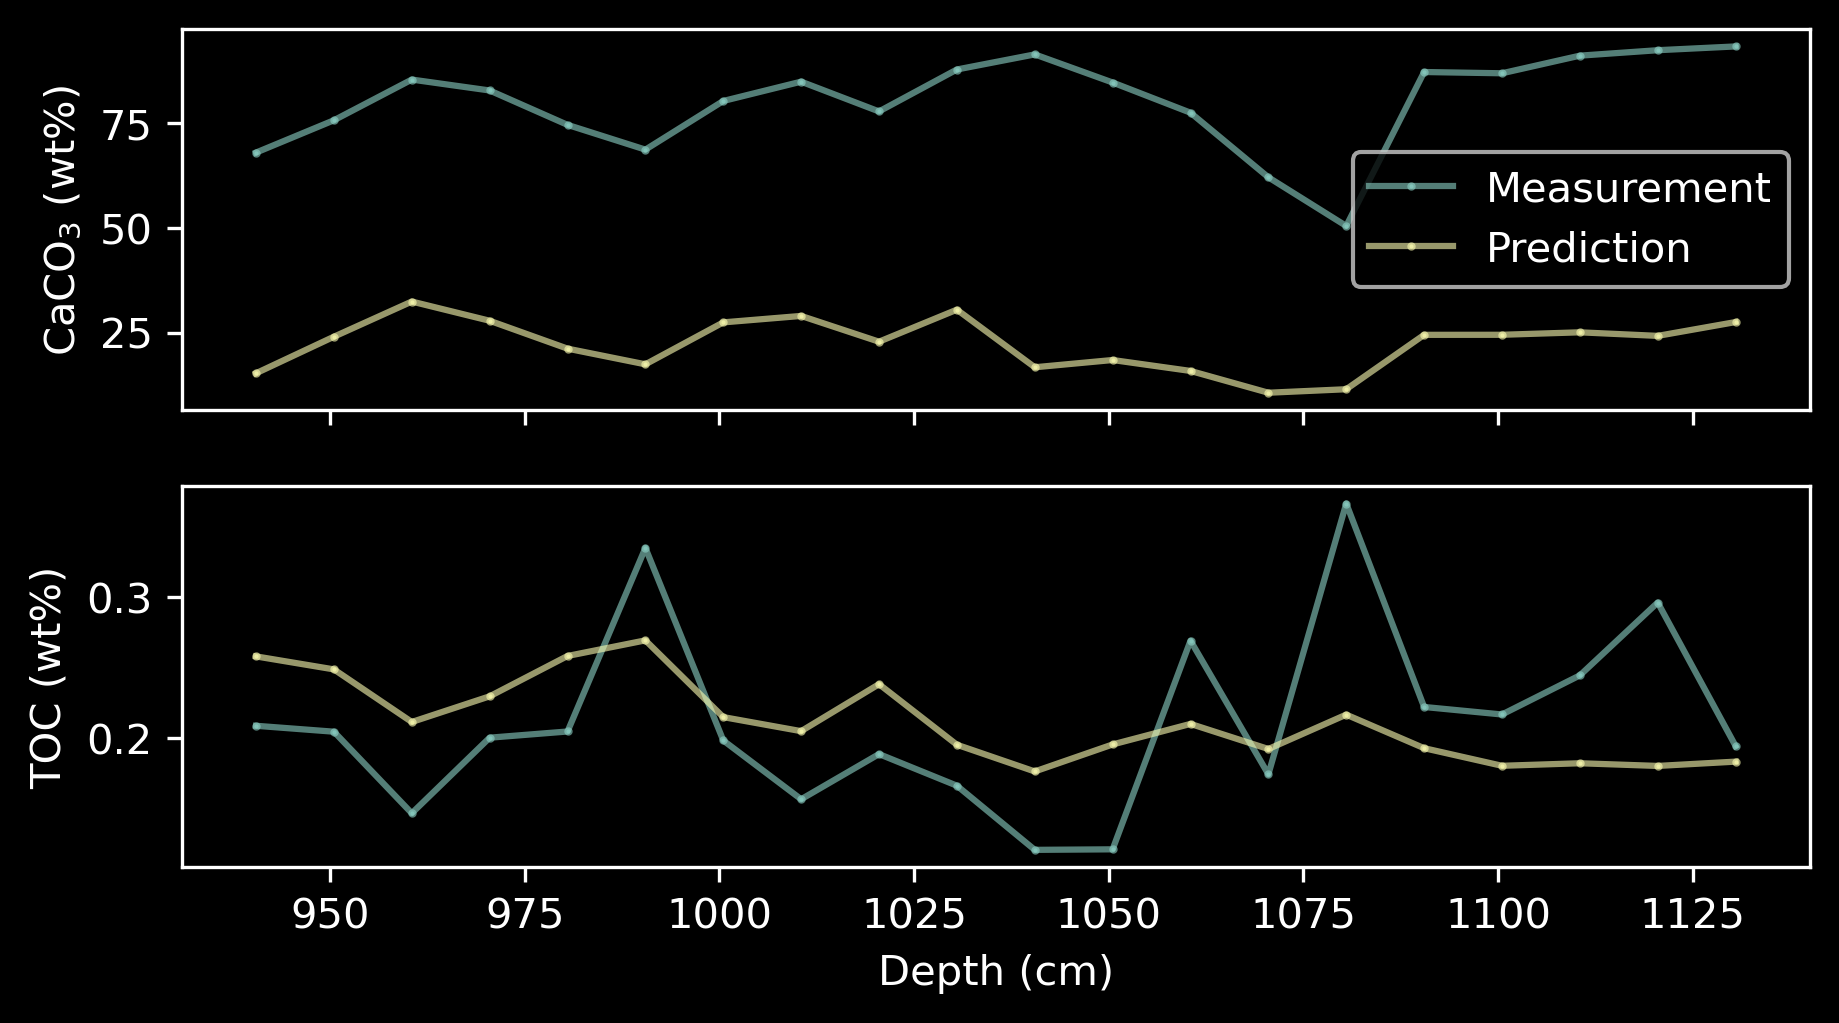

In [7]:
core = 'SO202-37-2_re'
fig, axes = plt.subplots(2, 1,figsize=(7, 3.7), sharex='col')
for measurement, ax in zip(['CaCO3%', 'TOC%'], axes):
    y = y_df.loc[y_df.core == core, measurement].dropna()
    y_pred = y_df.loc[y_df.core == core, '{}_pred'.format(measurement)].dropna()
    
    ax.plot(y_df.loc[y_df.core == core, 'mid_depth_mm']*0.1, y, 
             marker='o', ms=1, alpha=0.6, label='Measurement')
    ax.plot(y_df.loc[y_df.core == core, 'mid_depth_mm']*0.1, y_pred,
             marker='o', ms=1, alpha=0.6, label='Prediction')
    if measurement == 'CaCO3%':
        ax.set_ylabel('CaCO$_3$ (wt%)')
    else:
        ax.set_ylabel('TOC (wt%)')
axes[1].set_xlabel('Depth (cm)')
axes[0].legend(loc='center right')
plt.savefig('results/{}_performances_{}.png'.format(core, date))

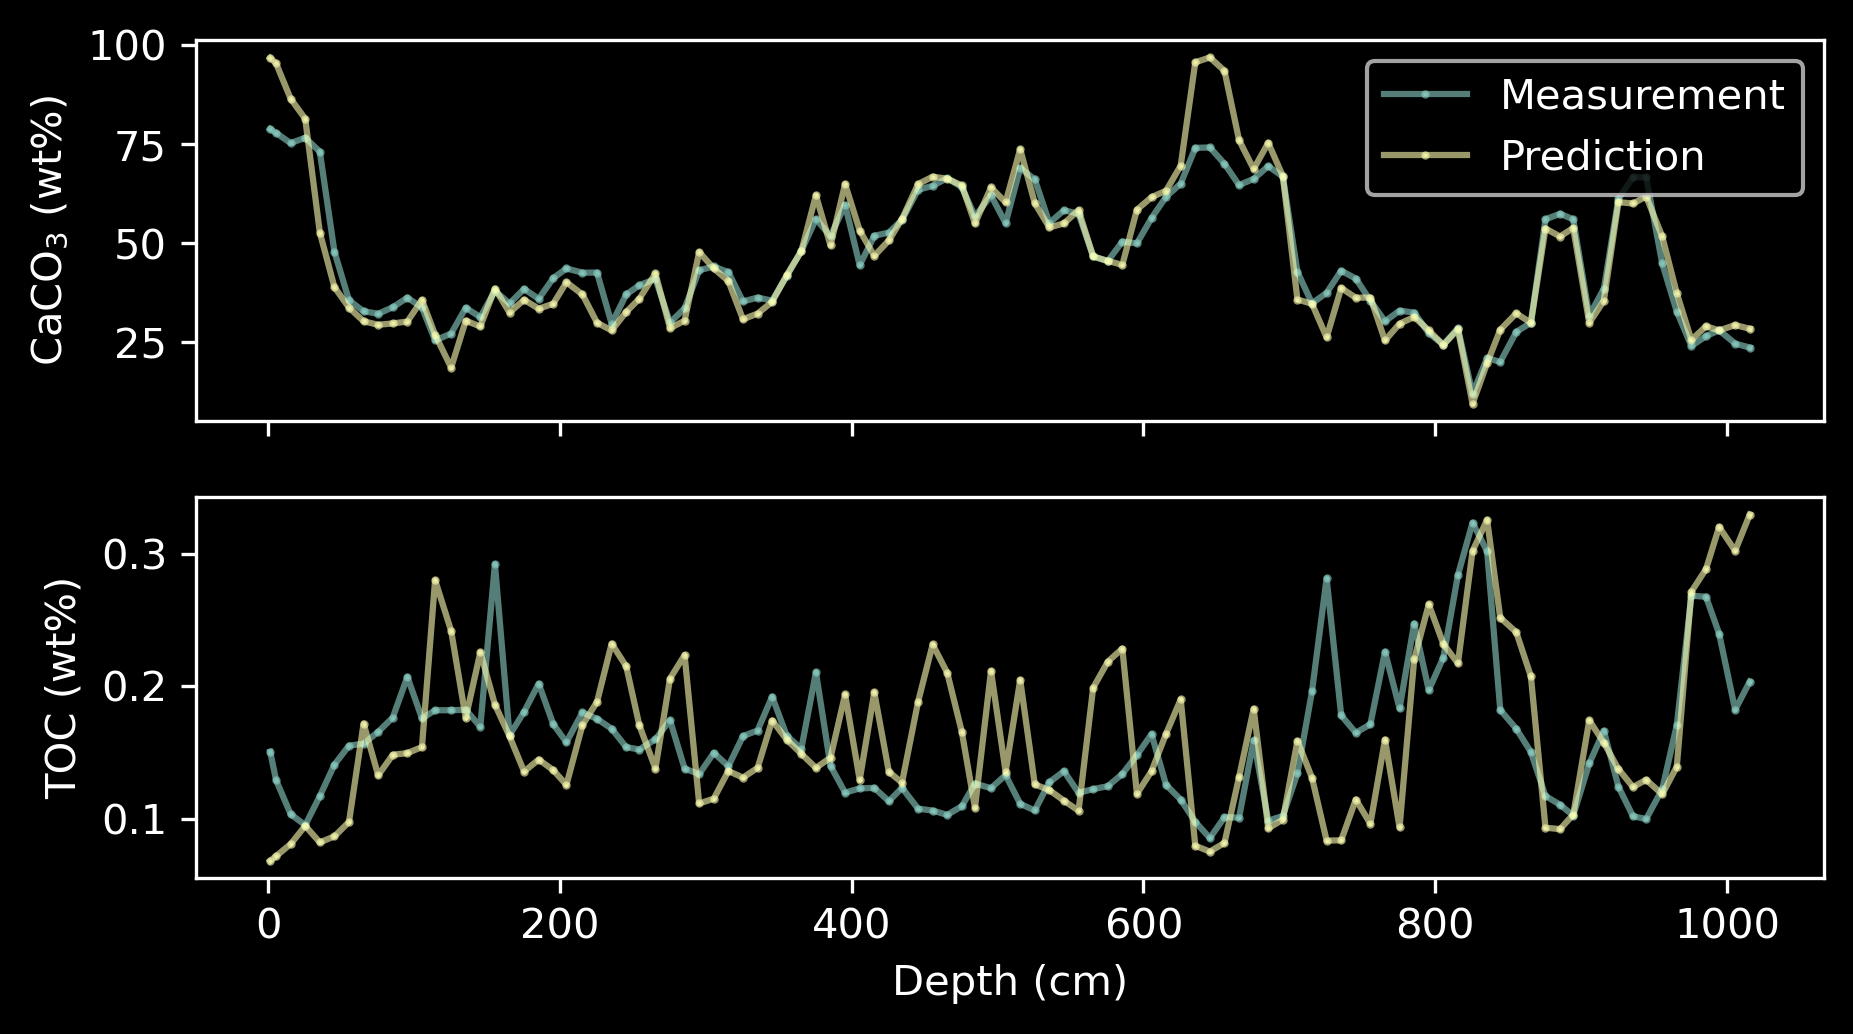

In [9]:
core = 'PS75-056-1'
fig, axes = plt.subplots(2, 1,figsize=(7, 3.7), sharex='col')
for measurement, ax in zip(['CaCO3%', 'TOC%'], axes):
    y = y_df.loc[y_df.core == core, measurement].dropna()
    y_pred = y_df.loc[y_df.core == core, '{}_pred'.format(measurement)].dropna()
    
    ax.plot(y_df.loc[y_df.core == core, 'mid_depth_mm']*0.1, y, 
             marker='o', ms=1, alpha=0.6, label='Measurement')
    ax.plot(y_df.loc[y_df.core == core, 'mid_depth_mm']*0.1, y_pred,
             marker='o', ms=1, alpha=0.6, label='Prediction')
    if measurement == 'CaCO3%':
        ax.set_ylabel('CaCO$_3$ (wt%)')
    else:
        ax.set_ylabel('TOC (wt%)')
axes[1].set_xlabel('Depth (cm)')
axes[0].legend(loc='upper right')
plt.savefig('results/{}_performances_{}.png'.format(core, date))

# Summary
The $R^{2}$ of both $CaCO_{3}$ and TOC in dev set are pretty good. But in the case study, the $R^{2}$ are as not good as in the dev set. TOC has the same issue like before: the case study's measurement values are too low. Even the mean and max. residuals are good (can check with JC), the $R^{2}$ are still bad in the both cores in the case study. I am not worry about it because it's explanable and expected. What I am worry about is $CaCO_{3}$ of the rescaned core SO202-37-2. It shows very bad $R^{2}$ and has clearly lower value in prediction comparing to the measurement. In contrast, core PS75-056-1 has excellent accuracy, so I need to dig out what makes the rescaned core SO202-37-2 different.

After discussing with JC, we decide to waive out the core SO202-37-2_rescan because the scanning head was a bit problemetic during the core's scan. Hence, we'll focus on the evaluation of the dev set and PS75-056-1 as the casestudy.